In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


In [2]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [3]:
#declear path to your mnist data folder
img_path = 'C:\\Users\\rajat\\Downloads\\archive\\trainingSet\\trainingSet'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))
#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
print
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [4]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    m_names = ['{}_{}'.format("managing_node", i+1) for i in range(5)]
    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    m_shards = [data[i:i + 2*size] for i in range(0,size*num_clients,size*2)]
    


    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))
    c={}
    m={}
    for i in range(len(client_names)):
        c[client_names[i]] = shards[i]

    for i in range(len(m_names)):
        m[m_names[i]] = m_shards[i]


    return (c,m)

In [5]:
clients,managing_nodes = create_clients(X_train, y_train,num_clients=10, initial='client')

In [22]:
print(clients['client_1'][101])

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01176471,
       0.00784314, 0.        , 0.        , 0.01960784, 0.01568627,
       0.        , 0.02352941, 0.02352941, 0.00784314, 0.01568627,
       0.01960784, 0.        , 0.        , 0.01568627, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01176471, 0.        , 0.00784314, 0.01176471,
       0.        , 0.        , 0.        , 0.04313725, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03529412,
       0.01568627, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00392157, 0.        , 0.00784314, 0.05882353,
       0.02352941, 0.        , 0.04705882, 0.01960784, 0.0392

In [6]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [7]:
#process and batch the training data for each client
clients_batched = dict()
managing_nodes_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [18]:
print(clients_batched['client_1'])

<BatchDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.int32)>


In [8]:
for (managing_node_name,data) in managing_nodes.items():
    managing_nodes_batched[managing_node_name] = batch_data(data)

In [9]:
managing_node_test=list()
for i in range(len(managing_nodes)):
    managing_node_test.append(tf.data.Dataset.from_tensor_slices((X_test[i:i+2], y_test[i:i+2])).batch(len(y_test[i:i+2])))

In [10]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [11]:

lr = 0.01 
comms_round = 50
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

c:\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

In [7]:
global_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
__________________________________________________

In [12]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [13]:
def test_model2(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | managing_node_acc: {:.3%} | managing_node_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [16]:
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
loss=[]
acc=[]
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss='categorical_crossentropy', 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    
    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        loss.append(global_loss)
        acc.append(global_acc)

132/132 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 88.571% | global_loss: 1.6714301109313965
132/132 [==============================] - 0s 3ms/step
comm_round: 1 | global_acc: 90.833% | global_loss: 1.6184245347976685
132/132 [==============================] - 0s 3ms/step
comm_round: 2 | global_acc: 91.976% | global_loss: 1.59931218624115
132/132 [==============================] - 0s 2ms/step
comm_round: 3 | global_acc: 92.333% | global_loss: 1.5892611742019653
132/132 [==============================] - 0s 2ms/step
comm_round: 4 | global_acc: 92.976% | global_loss: 1.580146074295044
132/132 [==============================] - 0s 2ms/step
comm_round: 5 | global_acc: 93.143% | global_loss: 1.5752205848693848
132/132 [==============================] - 0s 2ms/step
comm_round: 6 | global_acc: 93.667% | global_loss: 1.5693778991699219
132/132 [==============================] - 0s 1ms/step
comm_round: 7 | global_acc: 93.548% | global_loss: 1.5659083127975464
132

In [ ]:
global_model.save("F:/SegmentationModel/UNET/model-sdc-seg-v12.h5")


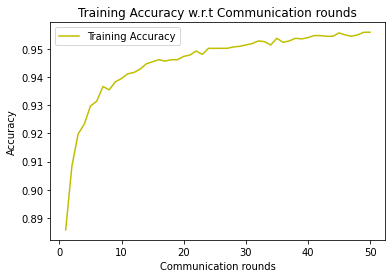

In [21]:
import matplotlib.pyplot as plt
acc = acc
c_round=[]
for i in range(50):
    c_round.append(i+1)


plt.plot(c_round, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy w.r.t Communication rounds')
plt.xlabel('Communication rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()